<a href="https://colab.research.google.com/github/SaideepGaunker/deepdetect/blob/main/cnn_deepfake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CNN MODEL perametor: 44M**

**Mounting Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Necessary Libraries **

In [4]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.saving import register_keras_serializable


**Loading GPU**

In [ ]:
# Check if the GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Enable dynamic memory growth for the GPU (optional)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU memory growth set up.")

Plot for Learning Rate  

In [6]:
class LivePlotCallback(Callback):
    def __init__(self):
        self.train_loss = []
        self.val_loss = []
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return

        # Store metrics
        self.train_loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.train_acc.append(logs["accuracy"])
        self.val_acc.append(logs["val_accuracy"])

        # Clear output and plot
        plt.figure(figsize=(10, 4))

        # Loss Plot
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss, label="Train Loss", color="blue")
        plt.plot(self.val_loss, label="Val Loss", color="red")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training & Validation Loss")

        # Accuracy Plot
        plt.subplot(1, 2, 2)
        plt.plot(self.train_acc, label="Train Accuracy", color="blue")
        plt.plot(self.val_acc, label="Val Accuracy", color="red")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Training & Validation Accuracy")

        plt.show()


**Plot for Accuracy and Loss **

In [7]:
class LRScheduleCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.lrs = []
        self.epochs = []

    def on_epoch_end(self, epoch, logs=None):
        current_lr = self.model.optimizer.learning_rate.numpy()
        self.lrs.append(current_lr)
        self.epochs.append(epoch)

        # Live plotting
        plt.figure(figsize=(8, 4))
        plt.plot(self.epochs, self.lrs, marker='o', linestyle='-')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Schedule")
        plt.grid(True)
        plt.show()

**Image loading and rescaling **

In [8]:
# Define image parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 200

# Create ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Rescale pixel values (0-255) to (0-1)
    rotation_range=20,            # Random rotation of images
    width_shift_range=0.2,        # Horizontal shift
    height_shift_range=0.2,       # Vertical shift
    shear_range=0.2,              # Shearing
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Flip images horizontally
    fill_mode='nearest'           # Fill any missing pixels after transformations
)

# Create ImageDataGenerator for validation and test (without augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data from the 'Train' folder
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/real_and_fake_face/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification task (fake/real)
)

# Load the validation data from the 'Validation' folder
validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/real_and_fake_face/validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

# Load the test data from the 'Test' folder
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/real_and_fake_face/test',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Don't shuffle test data
)

Found 1696 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 192 images belonging to 2 classes.


**Model**

In [9]:

# Model Definition (Functional API with Batch Normalization)
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))  # Input shape for the images

# First Convolutional block
x = layers.Conv2D(32, (3, 3), activation='leaky_relu')(inputs)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Second Convolutional block
x = layers.Conv2D(64, (3, 3), activation='leaky_relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Third Convolutional block
x = layers.Conv2D(128, (3, 3), activation='leaky_relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)

# Flatten the output from the convolutional layers
x = layers.Flatten()(x)

# Fully connected (Dense) layers
x = layers.Dense(512, activation='leaky_relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)  # Dropout to avoid overfitting

# Output layer for binary classification (fake/real)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = models.Model(inputs=inputs, outputs=outputs)


**Cyclical Learning Rate with Decay**

In [10]:
@register_keras_serializable(package="Custom")
class CyclicalLRDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr=1e-5, max_lr=1e-3, step_size=2000, decay_factor=0.99):
        super().__init__()
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.decay_factor = decay_factor

    def __call__(self, step):
        cycle = tf.floor(1 + step / (2 * self.step_size))
        x = tf.abs(step / self.step_size - 2 * cycle + 1)
        decayed_max_lr = self.max_lr * (self.decay_factor ** cycle)
        new_lr = self.initial_lr + (decayed_max_lr - self.initial_lr) * tf.maximum(0.0, (1 - x))
        return new_lr

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "max_lr": self.max_lr,
            "step_size": self.step_size,
            "decay_factor": self.decay_factor
        }


**Model compiling and summary**

In [11]:
clr_decay = CyclicalLRDecay(
    initial_lr=1e-5,
    max_lr=1e-3,
    step_size=1000
)
optimizer = tf.keras.optimizers.SGD(
    learning_rate=clr_decay,
    momentum=0.9,
    nesterov=True
)
# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,399,553 (169.37 MB)

 Trainable params: 44,398,081 (169.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

**Callbacks**

In [12]:

# Callbacks for saving models and early stopping
checkpoint_best = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/best_model.keras',
    monitor='val_loss',
    save_best_only=True
)

checkpoint_latest = callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/latest_model.keras',
    save_best_only=False
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,  # Increased patience
    restore_best_weights=True
)

# Add this callback to model.fit()
live_plot = LivePlotCallback()

# Instantiate the callback
lr_callback = LRScheduleCallback()

**Model fitting **

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.5002 - loss: 1.0625 

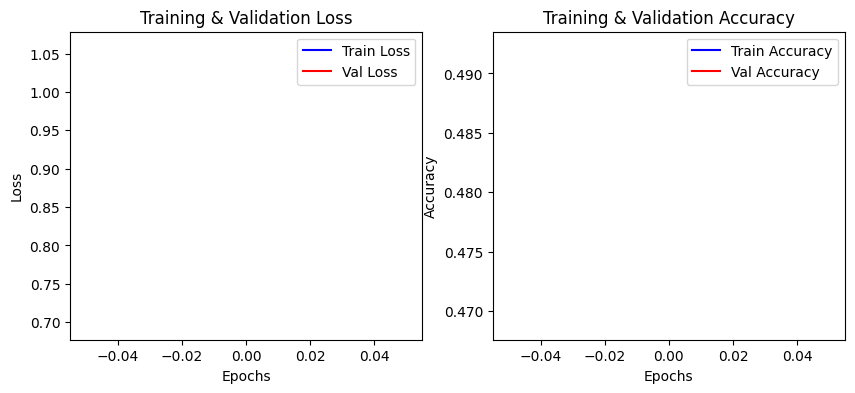

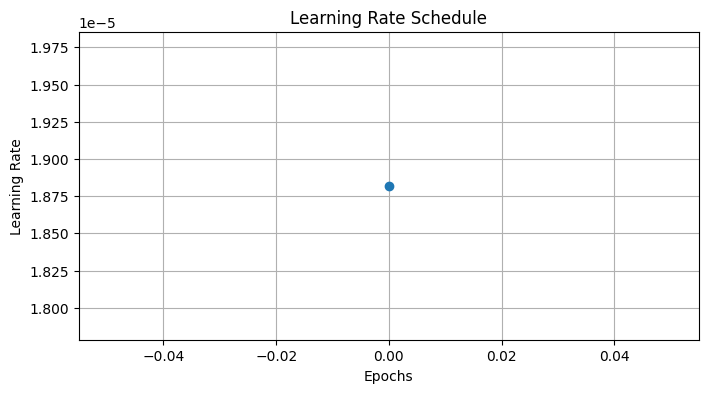

9/9 ━━━━━━━━━━━━━━━━━━━━ 376s 40s/step - accuracy: 0.4994 - loss: 1.0623 - val_accuracy: 0.4688 - val_loss: 0.6954
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5151 - loss: 1.0044

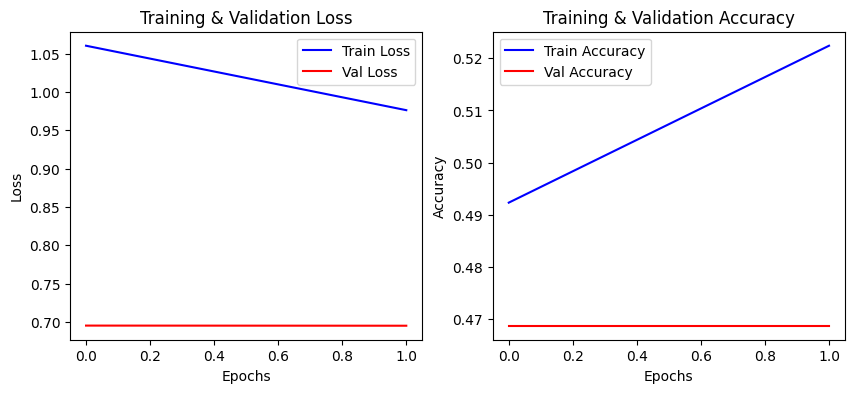

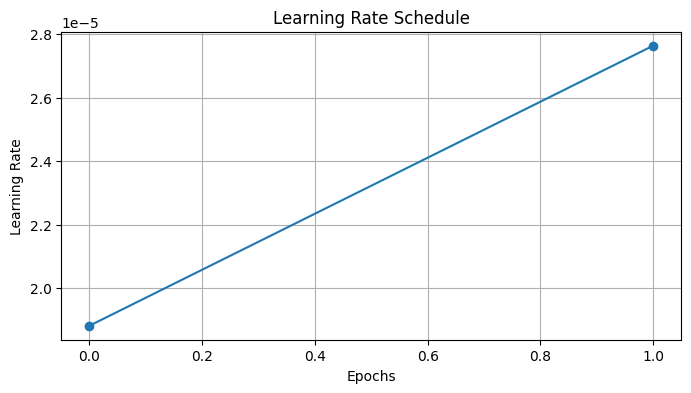

9/9 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.5159 - loss: 1.0016 - val_accuracy: 0.4688 - val_loss: 0.6952
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4900 - loss: 1.0312

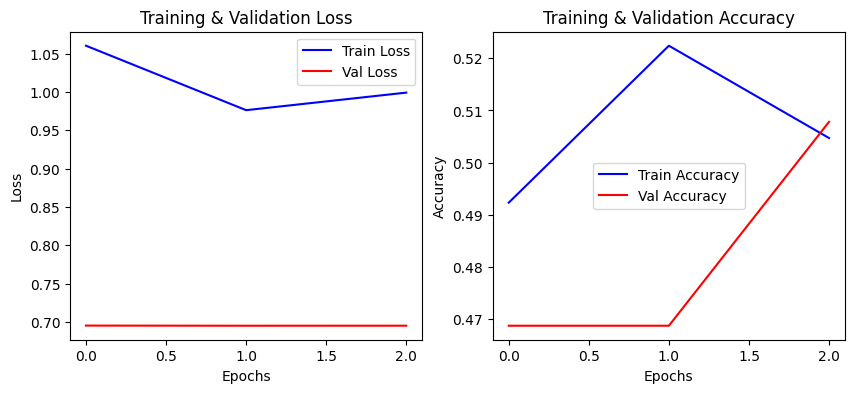

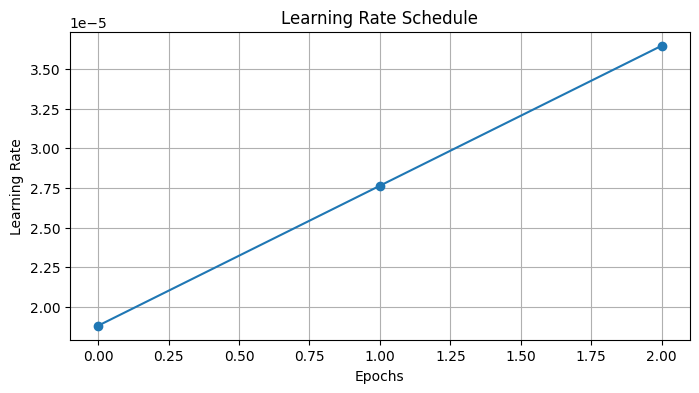

9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 5s/step - accuracy: 0.4915 - loss: 1.0280 - val_accuracy: 0.5078 - val_loss: 0.6953
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5132 - loss: 0.9938

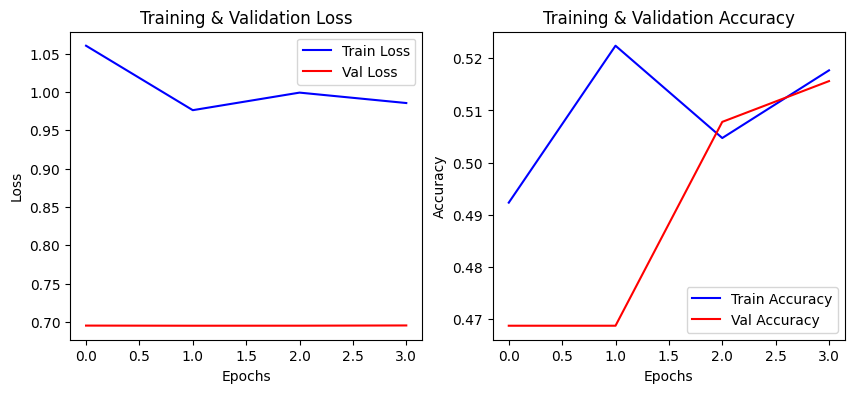

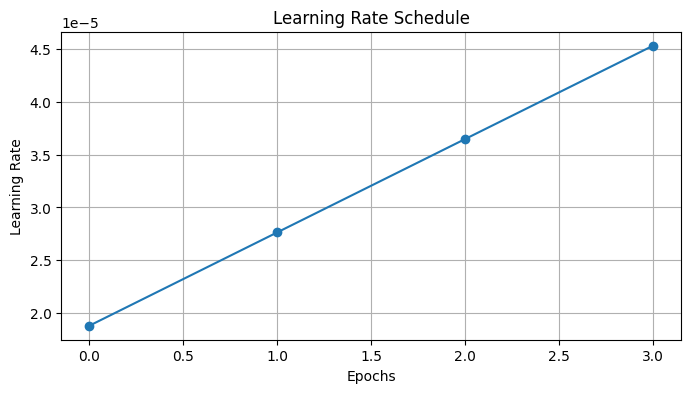

9/9 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.5136 - loss: 0.9930 - val_accuracy: 0.5156 - val_loss: 0.6956
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5382 - loss: 0.9533

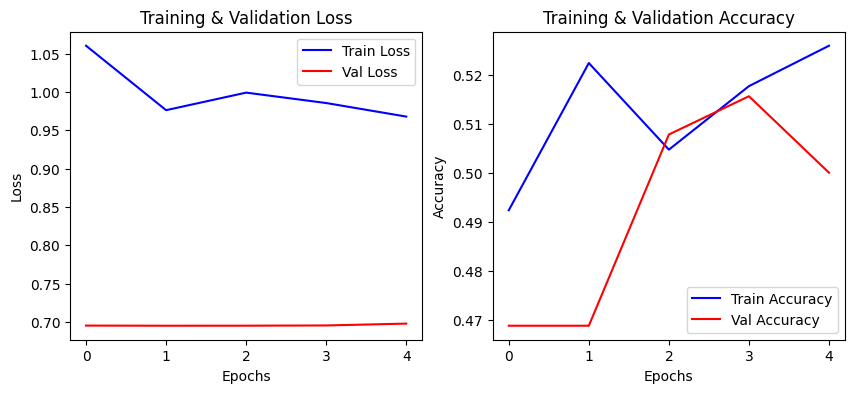

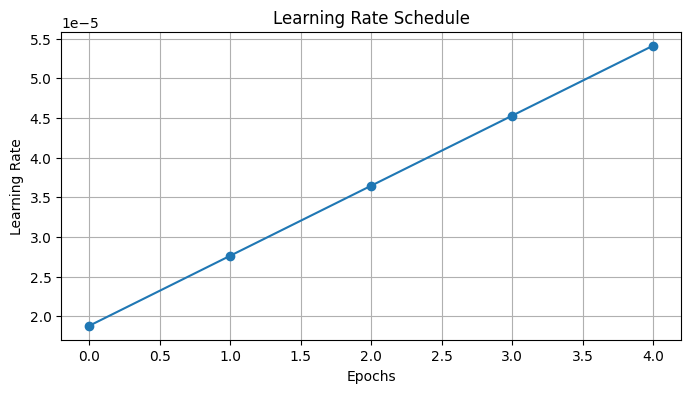

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5370 - loss: 0.9547 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5558 - loss: 0.9262

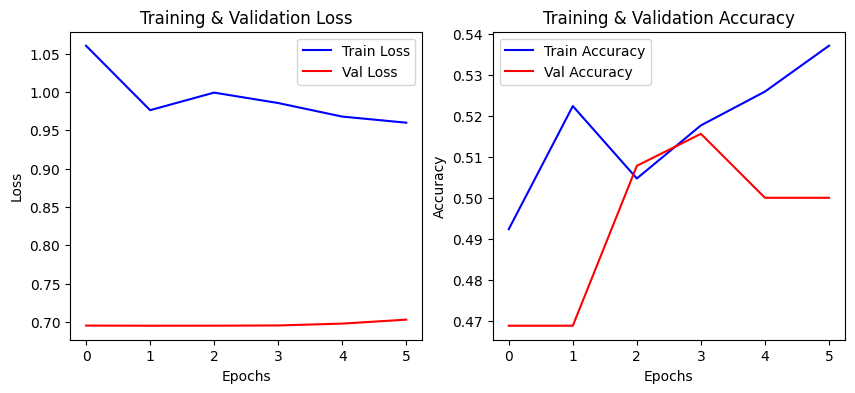

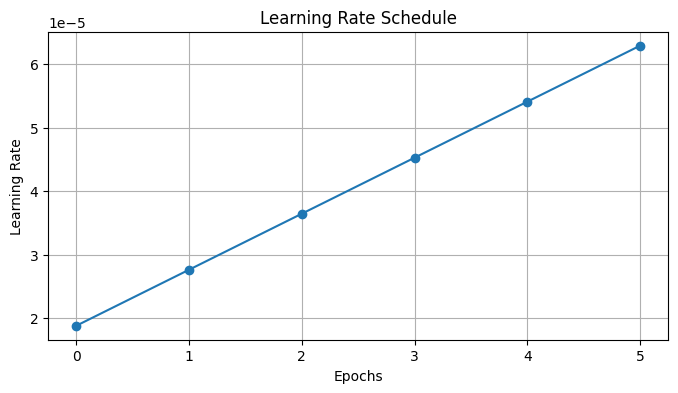

9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5539 - loss: 0.9296 - val_accuracy: 0.5000 - val_loss: 0.7032
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5166 - loss: 0.9197

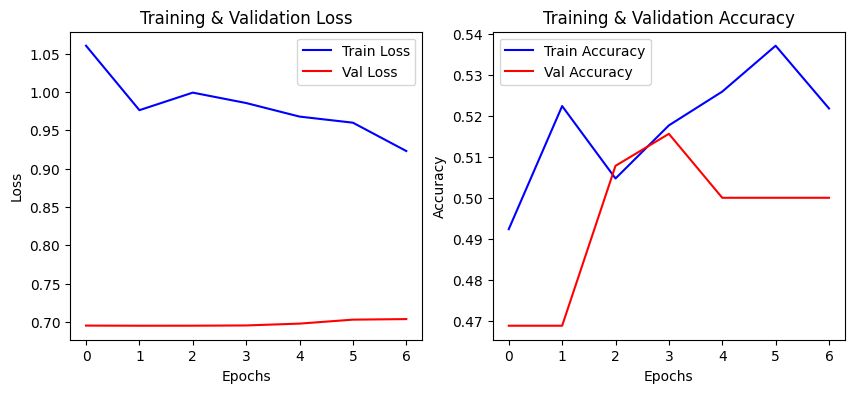

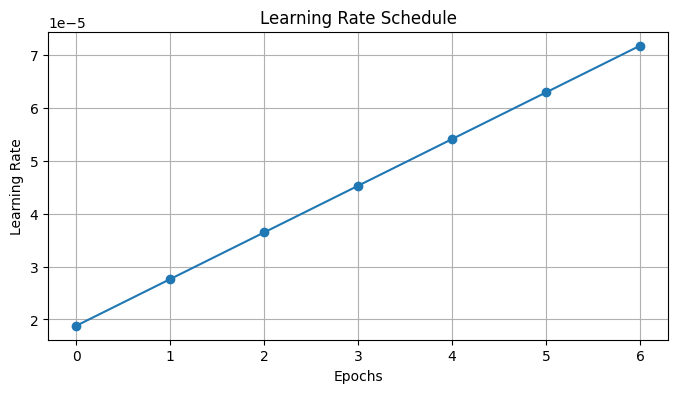

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5171 - loss: 0.9200 - val_accuracy: 0.5000 - val_loss: 0.7039
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5406 - loss: 0.9343

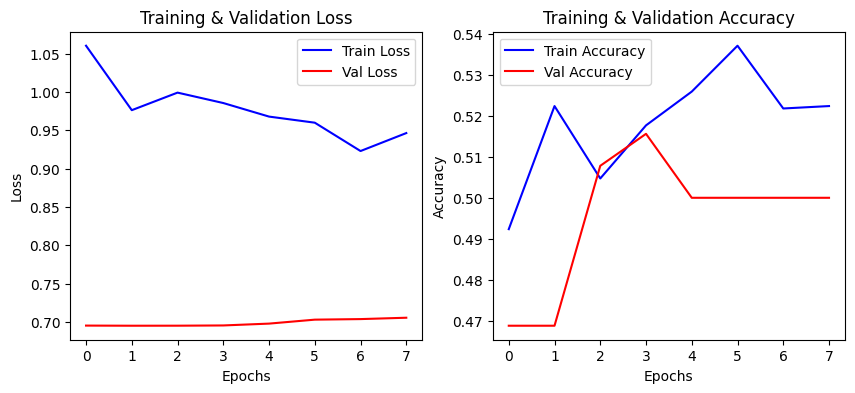

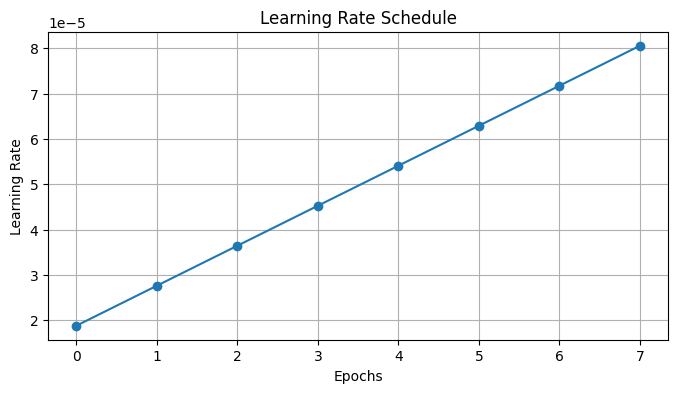

9/9 ━━━━━━━━━━━━━━━━━━━━ 43s 5s/step - accuracy: 0.5388 - loss: 0.9355 - val_accuracy: 0.5000 - val_loss: 0.7057
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5430 - loss: 0.8951

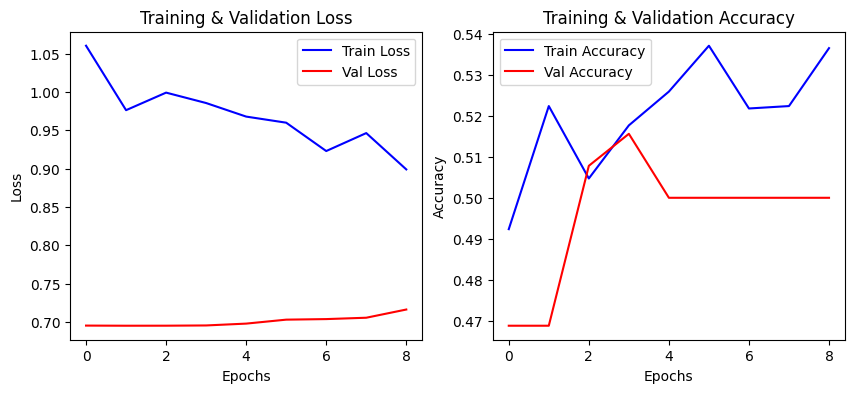

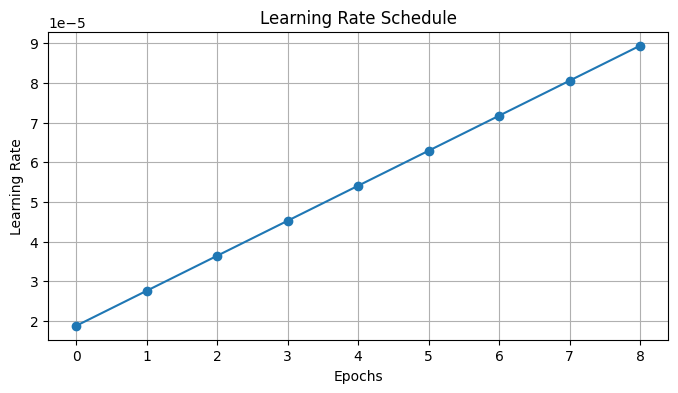

9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.5424 - loss: 0.8955 - val_accuracy: 0.5000 - val_loss: 0.7164
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5264 - loss: 0.9731

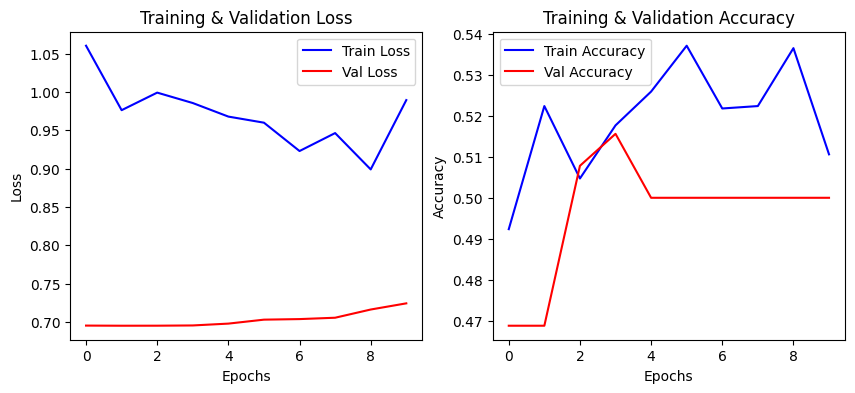

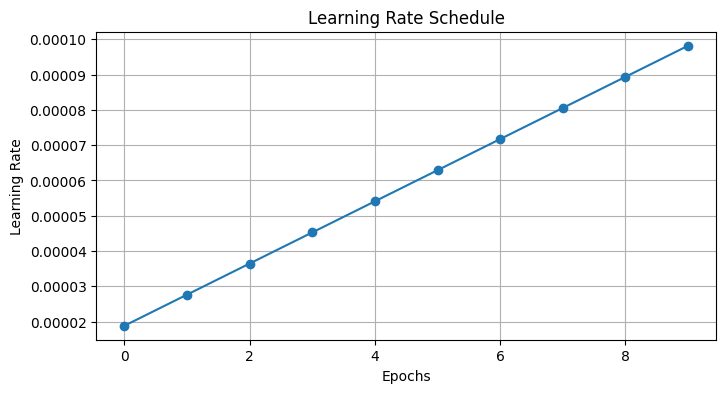

9/9 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.5248 - loss: 0.9748 - val_accuracy: 0.5000 - val_loss: 0.7244
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5365 - loss: 0.6922
Test accuracy: 0.5364583134651184, Test loss: 0.6922336220741272


In [13]:
# Fit the model
# use when data set is large
# history = model.fit(
#     train_generator,
#     steps_per_epoch=(train_generator.samples // BATCH_SIZE) * 2,  # Increase steps per epoch
#     epochs=10,
#     validation_data=validation_generator,
#     validation_steps=validation_generator.samples // BATCH_SIZE,
#     callbacks=[checkpoint_best, checkpoint_latest, early_stop, live_plot, lr_callback]
# )

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),  # Use the correct length
    epochs=10,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),  # Use correct length
    callbacks=[checkpoint_best, checkpoint_latest, early_stop, live_plot, lr_callback]
)


# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")


## **Model prediction**

In [14]:
# model loading
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/best_model.keras')

In [27]:

import cv2
import numpy as np
def preprocess_image(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0  # Rescale
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Example prediction
image_path = #image path
processed_image = preprocess_image(image_path)
prediction = model.predict(processed_image)

if prediction[0][0] > 0.5:
    print("Fake")
else:
    print("Real")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Real
